In [1]:
import pandas as pd
import glob
import os
import json
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics
from tqdm import tqdm
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def cluster_data(df):
    processed_articles, amount_of_articles = count_articles(df)
    tfidf, words = convert_to_tfidf(processed_articles)
    all_kmeans_models, common_words, mapping1, mapping2, K, distortions = calculate_kMeans(tfidf, words)
    knee = calculate_knee(K, distortions)
    cluster_words_list, df = gather_top_words(all_kmeans_models, knee, words, df)
    df = assign_top_words(cluster_words_list, df)
    df = date_month_publish(df)
    create_cluster_files(df)
    return amount_of_articles

# Load JSON Files into Pandas Dataframe

In [3]:
def count_articles(df):
    amount_of_articles = len(df["filtered_maintext"])
    processed_articles = df['filtered_maintext']
    return processed_articles, amount_of_articles

In [4]:
def convert_to_tfidf(processed_articles):
    tfidfconverter = TfidfVectorizer(lowercase=True, stop_words='english', min_df=0.05 , max_df=0.6)  
    tfidf = tfidfconverter.fit_transform(processed_articles)
    words = tfidfconverter.get_feature_names()
    return tfidf, words

In [5]:
from sklearn.metrics.pairwise import cosine_distances

#cosine_similarity = cosine_distances(tfidf)
#cosine_similarity

In [6]:
from sklearn.cluster import AffinityPropagation

In [7]:
'''
clustering = AffinityPropagation(convergence_iter=5, affinity='precomputed', random_state=10)
clustering.fit(cosine_similarity)
labels = clustering.labels_
print(labels.dtype)
#cluster_centers = clustering.cluster_centers_
cluster_centers_indices = clustering.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
print(n_clusters_)'''

"\nclustering = AffinityPropagation(convergence_iter=5, affinity='precomputed', random_state=10)\nclustering.fit(cosine_similarity)\nlabels = clustering.labels_\nprint(labels.dtype)\n#cluster_centers = clustering.cluster_centers_\ncluster_centers_indices = clustering.cluster_centers_indices_\nn_clusters_ = len(cluster_centers_indices)\nprint(n_clusters_)"

In [8]:
'''
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = cosine_similarity[cluster_centers_indices[k]]
    plt.plot(cosine_similarity[class_members, 0], cosine_similarity[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in cosine_similarity[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()'''

"\nimport matplotlib.pyplot as plt\nfrom itertools import cycle\n\nplt.close('all')\nplt.figure(1)\nplt.clf()\n\ncolors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')\nfor k, col in zip(range(n_clusters_), colors):\n    class_members = labels == k\n    cluster_center = cosine_similarity[cluster_centers_indices[k]]\n    plt.plot(cosine_similarity[class_members, 0], cosine_similarity[class_members, 1], col + '.')\n    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,\n             markeredgecolor='k', markersize=14)\n    for x in cosine_similarity[class_members]:\n        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)\n\nplt.title('Estimated number of clusters: %d' % n_clusters_)\nplt.show()"

In [9]:
'''
df['processed_articles'] = processed_articles
df['affpropID'] = clustering.labels_'''


"\ndf['processed_articles'] = processed_articles\ndf['affpropID'] = clustering.labels_"

In [10]:
#df.head()

In [11]:
def calculate_kMeans(tfidf, words):
    max_clusters = 10
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}

    last_distortion = 0

    all_kmeans_models = []

    K = range(2,max_clusters)
    X = np.matrix(tfidf.toarray())
    print("Generating the K-Means model...")
    for i in tqdm(K):
        #print("Iteration: " + str(i))
        kMeans = KMeans(n_clusters=i, max_iter=400).fit(tfidf)
        kMeans.predict(tfidf)
        labels = kMeans.labels_
        cluster_centers = kMeans.cluster_centers_
        inertias.append(kMeans.inertia_)
        distortions.append(sum(np.min(cdist(X, cluster_centers, 'euclidean'), axis=1)) / X.shape[0])

        this_silhouette = metrics.silhouette_score(tfidf.toarray(), labels, metric='sqeuclidean')

        #print("Silhouette Score: " + str(this_silhouette))

        mapping1[i] =  sum(np.min(cdist(X, cluster_centers, 'euclidean'), axis=1)) / X.shape[0]
        mapping2[i] = kMeans.inertia_

        all_kmeans_models.append(kMeans)

        common_words = kMeans.cluster_centers_.argsort()[:,-1:-11:-1]
        #for num, centroid in enumerate(common_words):
            #print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
    return all_kmeans_models, common_words, mapping1, mapping2, K, distortions

In [12]:
def calculate_knee(K, distortions):
    try:
        #print("The elbow point of the curve is: ")
        #print('K: ',len(K))
        #print('dis: ', len(distortions))
        kneedle = KneeLocator(K, distortions, S=1.0, curve="convex", direction="decreasing")
        #print(kneedle.knee_y)
        kneedle.plot_knee()
        return kneedle.knee
    except:
        print("Could not find an elbow point. Continuing with the lowest distortion.")
        min_distortion = max(distortions)
        min_index = distortions.index(min_distortion)
        return K[min_index]

In [13]:
#plt.plot(K, inertias, 'bx-')
#plt.xlabel('Values of K')
#plt.ylabel('Inertia')
#plt.title('The Elbow Method using Inertia')
#plt.show()

In [14]:
#plt.plot(K, distortions, 'bx-')
#plt.xlabel('Values of K')
#plt.ylabel('Distortion')
#plt.title('The Elbow Method using Distortion')
#plt.show()

In [15]:
def gather_top_words(all_kmeans_models, knee, words, df):
    # save the clusterIDs to the dataframe
    # minus 2 because we start checking with 2 clusters
    df["kMeans_ID"] = all_kmeans_models[knee-2].labels_
    cluster_words_list = []
    common_words = all_kmeans_models[knee-2].cluster_centers_.argsort()[:,-1:-11:-1]
    for num, centroid in enumerate(common_words):
        cluster_words = []
        for word in centroid:
            cluster_words.append(words[word])
        cluster_words_list.append(cluster_words)
    return cluster_words_list, df

In [16]:
def assign_top_words(cluster_words_list, df):
    row_words = []
    for index, row in df.iterrows():
        cluster = row.kMeans_ID
        row_words.append(cluster_words_list[cluster])
    df['kMeans_words'] = row_words
    return df


# Subcluster by release date

We will determine each articles release date and sort them into individual json files.

In [17]:
def getMonthYear(s):
     return s.split('-')[0]+"-"+s.split('-')[1]

# Generating folder structure

The following code creates the desired folder hierarchy and names each cluster after the top 3 dominant words in each one. Within each cluster/folder we are subclustering all articles by their release date.
The output json file has the format *year-month.json*. 

In [18]:
def date_month_publish(df):
    df['date_publish'] = pd.to_datetime(df['date_publish'])
    df['month_year'] = df['date_publish'].apply(lambda x: getMonthYear(str(x)))
    return df

In [19]:
def create_cluster_files(df):

    item_LDA = df.iloc[0]["topic_keywords"]  # the top words from the lda clustering
    item_LDA = item_LDA.split(", ") # make string a list
    cluster_id_LDA = df.iloc[0]["LDA_ID"]
    print("ILOC: " + str(cluster_id_LDA))
    level1_directory = f'./clustered_json/cluster_{cluster_id_LDA}-{item_LDA[0]}_{item_LDA[1]}_{item_LDA[2]}'
    os.makedirs(level1_directory)   # create the directory for the LDa clustering level

    for cluster_id_kMeans, data in df.groupby(df.kMeans_ID):
        item_kMeans = data.kMeans_words.tolist()[0]     # the top words from the kMeans clustering
        os.makedirs(f'{level1_directory}/cluster_{cluster_id_kMeans}-{item_kMeans[0]}_{item_kMeans[1]}_{item_kMeans[2]}_{item_kMeans[3]}_{item_kMeans[4]}')     #create the directory for the level 2 kMeans clustering
        for date, date_data in data.groupby(data.month_year):
            json_data = date_data.to_json(orient='records', force_ascii=False, date_format='iso', date_unit='s')
            parsed = json.loads(json_data)
            with open(f'{level1_directory}/cluster_{cluster_id_kMeans}-{item_kMeans[0]}_{item_kMeans[1]}_{item_kMeans[2]}_{item_kMeans[3]}_{item_kMeans[4]}/{date}.json', 'w', encoding='utf-8') as f:  #create the json file for the level 3 timed events
                f.write(json.dumps({"data": parsed}, indent=4, ensure_ascii=False))

Executing code for main cluster  0
Generating the K-Means model...


100%|██████████| 8/8 [02:04<00:00, 15.58s/it]


KeyError: 'LDA_ID'

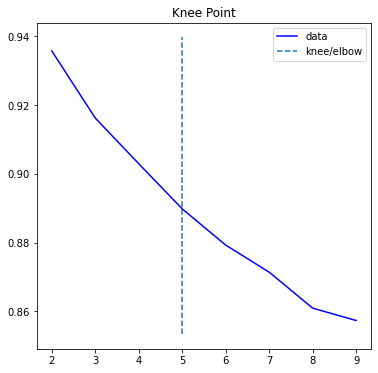

In [20]:
path = 'lda_clustered_json/'    # the path of the folder where the lda clustered articles are in

amount_of_articles = 0
i = 0
for filename in glob.glob(os.path.join(path, '*.json')):
    print("Executing code for main cluster ", str(i))
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        df = pd.read_json(currentFile, orient='index')
        amount_of_articles = cluster_data(df)
    print("Finished multi level clustering of main cluster " + str(i) + ". Processed " + str(amount_of_articles) + " articles.")
    i = i+1